In [1]:
!pip install xgboost

In [2]:
# And, if needed: sudo apt install graphviz
!pip install graphviz

In [3]:
import xgboost as xgb

In [4]:
import os

In [5]:
if not os.path.exists('lending-club'):
    print("======================================================")
    print("Make sure to download the lending club dataset into `lending-club`")
    print("https://www.kaggle.com/wendykan/lending-club-loan-data")
    print("======================================================")
    assert False

## Explore dataset

In [6]:
import random
import numpy as np
import pandas as pd


In [7]:
filename = 'lending-club/loan.csv'
num_total = sum(1 for line in open(filename)) - 1 # number of records in file (without header)
num_sample = 100_000
skiprows = sorted(random.sample(range(1, num_total+1), num_total-num_sample)) # the 0-indexed header will not be included in the skip list

df = pd.read_csv(filename,
                low_memory=False,  # disables loading in chunks, which in this case causes inconsistent type inference
                skiprows=skiprows  # operating on all rows kills my 16gig memory further down in the notebook. for actual training I'd need all
                )

print(f"Loaded {filename}. Sampled {num_sample} from a total of {num_total} records, which is {100*num_sample/num_total:.1f} percent)")

Loaded lending-club/loan.csv. Sampled 100000 from a total of 2260668 records, which is 4.4 percent)


In [8]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,4000,4000,4000.0,36 months,11.80,132.48,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,7500,7500,7475.0,36 months,11.80,248.40,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,26000,26000,26000.0,60 months,18.94,673.60,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Each loan has its official grade ranking provided by Lending Club (let's maybe not use this a a feature)
df.grade.unique()

array(['D', 'B', 'A', 'E', 'C', 'G', 'F'], dtype=object)

In [10]:
# It's even more fine-graned. Same story: This is their official rating, let's be intentional about using/not using it as a feature
df.sub_grade.unique()

array(['D2', 'B4', 'D5', 'A5', 'E3', 'D1', 'B5', 'C3', 'C2', 'D4', 'B1',
       'C5', 'D3', 'A4', 'C1', 'B2', 'B3', 'A1', 'C4', 'E1', 'A2', 'A3',
       'E2', 'E4', 'E5', 'G1', 'F1', 'F2', 'F3', 'G5', 'F5', 'F4', 'G4',
       'G3', 'G2'], dtype=object)

Interest rates ranking from 5.31 to 30.99, median: 12.62, mean 13.0986526


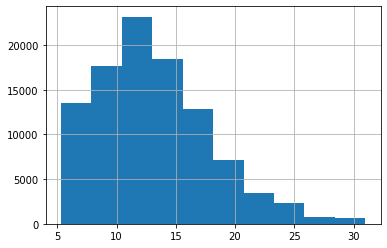

In [11]:
print(f'Interest rates ranking from {df.int_rate.min()} to {df.int_rate.max()}, median: {df.int_rate.median()}, mean {df.int_rate.mean()}')
df.int_rate.hist()

In [12]:
# cool, but not for a dataset with that many features
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,0.0,99916.000000,...,467.0,467.000000,467.0,467.000000,370.000000,467.000000,467.000000,1465.000000,1465.000000,1465.000000
mean,NaN,NaN,15076.043250,15071.687500,15053.028370,13.098653,446.547825,7.813432e+04,NaN,18.862404,...,3.0,157.219957,3.0,13.443255,463.507054,11870.374561,194.682334,4982.665659,47.737181,13.352218
std,NaN,NaN,9211.873555,9210.694817,9215.286751,4.810018,267.441756,7.873348e+04,NaN,14.925483,...,0.0,124.535305,0.0,10.011715,371.850563,7692.189221,209.277546,3643.324129,6.543110,8.129092
min,NaN,NaN,900.000000,900.000000,0.000000,5.310000,24.960000,0.000000e+00,NaN,0.000000,...,3.0,5.480000,3.0,0.000000,16.440000,474.490000,0.020000,82.960000,20.000000,0.000000
25%,NaN,NaN,8000.000000,8000.000000,8000.000000,9.580000,251.680000,4.600000e+04,NaN,11.950000,...,3.0,59.555000,3.0,1.500000,173.115000,5699.050000,34.715000,2200.000000,45.000000,6.000000
50%,NaN,NaN,12825.000000,12800.000000,12800.000000,12.620000,378.860000,6.500000e+04,NaN,17.850000,...,3.0,125.150000,3.0,15.000000,370.170000,10145.910000,117.060000,4080.780000,45.000000,14.000000
75%,NaN,NaN,20000.000000,20000.000000,20000.000000,15.990000,594.780000,9.300000e+04,NaN,24.462500,...,3.0,228.870000,3.0,23.000000,667.432500,17036.265000,294.545000,6911.000000,50.000000,18.000000
max,NaN,NaN,40000.000000,40000.000000,40000.000000,30.990000,1618.030000,9.000000e+06,NaN,999.000000,...,3.0,768.810000,3.0,30.000000,2306.430000,34239.630000,1206.060000,21421.640000,88.820000,36.000000


In [13]:
# Probably our target variable: Was the loan repaid in the end?
df.loan_status.value_counts()

Fully Paid                                             46176
Current                                                40642
Charged Off                                            11591
Late (31-120 days)                                       967
In Grace Period                                          361
Late (16-30 days)                                        163
Does not meet the credit policy. Status:Fully Paid        61
Does not meet the credit policy. Status:Charged Off       38
Default                                                    1
Name: loan_status, dtype: int64

In [33]:
# Determining the loans that are bad from loan_status column
# Source of this snippet: https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics

bad_loan_columns = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
    "In Grace Period", 
    "Late (16-30 days)",
    "Late (31-120 days)"
]

df['loan_condition'] = np.nan    
df['loan_condition'] = df['loan_status'].isin(bad_loan_columns)

In [34]:
df.loan_condition.value_counts()

False    86879
True     13121
Name: loan_condition, dtype: int64

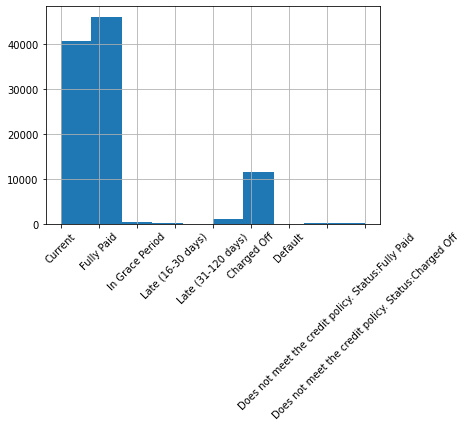

In [35]:
df.loan_status.hist(xrot=45)

In [17]:
# print("\n".join(df.columns))

In [18]:
# list(df.select_dtypes(include=[np.number]).columns.values)

## Prepare dataset for training

In [19]:
df_for_training = df.drop(columns=[
    # these features only exist post facto, so we dont want them to predict bad debt
    'grade',
    'sub_grade',
    'recoveries',
    'total_rec_late_fee',
    'last_pymnt_amnt',
    # these features are individual identifiers and dont help the classifier
    'url',
    'id',
    'member_id'])
df_for_training

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_condition
0,30000,30000,30000.0,60 months,18.94,777.23,Postmaster,10+ years,MORTGAGE,90000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
1,4000,4000,4000.0,36 months,11.80,132.48,NaN,NaN,RENT,20000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
2,7500,7500,7475.0,36 months,11.80,248.40,NaN,NaN,MORTGAGE,32700.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
3,26000,26000,26000.0,60 months,18.94,673.60,Mortgage loan processor,10+ years,MORTGAGE,40000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
4,30000,30000,30000.0,36 months,22.35,1151.16,Supervisor,5 years,MORTGAGE,100000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,21625,21625,21625.0,36 months,17.09,771.96,teacher,10+ years,MORTGAGE,83000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,True
99996,5000,5000,5000.0,36 months,22.91,193.32,Teacher,4 years,RENT,40000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
99997,10175,10175,10175.0,36 months,18.06,368.16,Senior Accountant,10+ years,RENT,56000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
99998,16000,16000,15950.0,36 months,17.09,571.17,pharmacist,3 years,RENT,115000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False


In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_for_training, test_size=0.2)

In [21]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_condition
93871,6000,6000,6000.0,36 months,12.98,202.11,SOUTHEAST KANSAS EDUCATION SERVICE CENTE,9 years,MORTGAGE,76000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
83140,28000,28000,28000.0,36 months,16.49,991.19,human resources,10+ years,MORTGAGE,104000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
50149,18000,18000,17875.0,36 months,10.99,589.22,Total Rewards Manager,10+ years,RENT,84000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
42917,15000,15000,15000.0,36 months,16.55,531.44,Computer Specialist,7 years,OWN,83500.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False
16638,15000,15000,15000.0,60 months,13.58,345.77,Mechanical Engineer,10+ years,OWN,120000.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,False


In [22]:
# convert target to 0 and 1
y_train = train.loan_condition.apply(int)
y_test = test.loan_condition.apply(int)

# remove target from features
x_train = train.drop(columns=['loan_condition'])
x_test = test.drop(columns=['loan_condition'])

# for now: only work on numerical features.
# TODO: we can also make categorical ones work
x_train = (
    x_train
   .select_dtypes(include=[np.number])
)
x_test = (
    x_test
    .select_dtypes(include=[np.number])
)

# impute NaN values
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

In [23]:
x_train

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
93871,6000,6000,6000.0,12.98,202.11,76000.0,23.32,0,0,33.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
83140,28000,28000,28000.0,16.49,991.19,104000.0,27.91,0,0,50.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
50149,18000,18000,17875.0,10.99,589.22,84000.0,26.50,0,0,40.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
42917,15000,15000,15000.0,16.55,531.44,83500.0,19.79,1,4,21.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
16638,15000,15000,15000.0,13.58,345.77,120000.0,2.88,0,2,37.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59296,20000,20000,20000.0,10.49,649.96,109000.0,25.66,0,2,59.000000,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
25808,8000,8000,8000.0,11.49,263.78,36500.0,34.46,0,0,34.609148,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
46950,15000,15000,15000.0,18.25,382.95,30000.0,19.08,0,0,34.609148,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
84744,15000,15000,15000.0,7.69,301.93,108000.0,22.09,0,0,34.609148,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328


In [24]:
# Targets should be ones and zeros
y_train

93871    0
83140    0
50149    0
42917    0
16638    0
        ..
59296    0
25808    0
46950    1
84744    0
28133    0
Name: loan_condition, Length: 80000, dtype: int64

In [25]:
# How many features do we train on? -> 106
x_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
93871,6000,6000,6000.0,12.98,202.11,76000.0,23.32,0,0,33.0,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
83140,28000,28000,28000.0,16.49,991.19,104000.0,27.91,0,0,50.0,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
50149,18000,18000,17875.0,10.99,589.22,84000.0,26.50,0,0,40.0,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
42917,15000,15000,15000.0,16.55,531.44,83500.0,19.79,1,4,21.0,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328
16638,15000,15000,15000.0,13.58,345.77,120000.0,2.88,0,2,37.0,...,3.0,154.250746,3.0,13.475124,454.080949,11785.112935,193.166219,4893.832348,47.76886,13.351328


## XGBoost

In [26]:
# xgboost prefers its own data dataformat. But we can convert from the pandas dataframe
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic'
}
num_rounds = 2
bst = xgb.train(param, dtrain, num_rounds)

In [27]:
y_pred = bst.predict(dtest)

In [28]:
y_pred.shape

(20000,)

## Evaluate classifier performance

In [29]:
import math
from sklearn.metrics import classification_report

In [30]:
# convert float scores to zeros and ones
y_pred_binary = [int(round(score)) for score in y_pred]

report = classification_report(
    y_true=y_test,
    y_pred=y_pred_binary,
    target_names=["Good loan", "Bad Loan"]
)

print(report)

              precision    recall  f1-score   support

   Good loan       0.94      1.00      0.97     17338
    Bad Loan       1.00      0.57      0.73      2662

    accuracy                           0.94     20000
   macro avg       0.97      0.79      0.85     20000
weighted avg       0.95      0.94      0.94     20000



## What has the model learned?

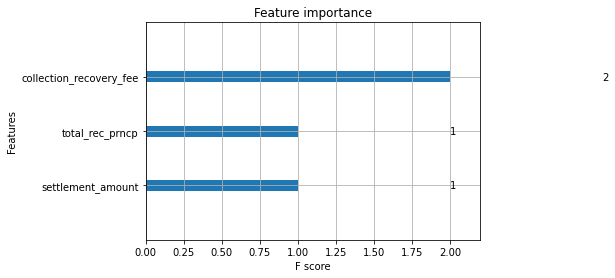

In [31]:
# careful: this is not a good metric of feature importance, because it simply counts the splits in a tree.
# Alternatioves: Shapley feature importance, Lime feature importance
xgb.plot_importance(bst)

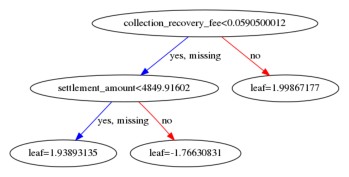

In [32]:
xgb.plot_tree(bst)

## TODO: Hand-remove features before training!
disable all features which only exist for loans after they have clearly defaultet (like late collection fees). Otherwise the model will simply look at them. When a new user applies for a loan, we obviously do not have that data yet. 

To understand what each feature means, there is a table in the xls file that comes with the dataset. Unfortunately it does not seem to include all features, or they are spelled differently.

- remove features that allow cheating
- don't use `.apply()`, there are often more and faster options (like `isin()`)
- learn more and deeper trees
- run on whole dataset